In [51]:
import pandas as pd

# Read dataframe
wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

# Add binary outcome variable
wide_df["surg_engel_binary"] = wide_df["surg_engel"]==1

BA_df = pd.read_csv("../../data/processed/NYU_PyBrainAge_Output_20240716.csv")
BA_df = BA_df.rename(columns={"ID":"record_id",
                              "BrainPAD":"BA_pred"})

wide_df = pd.merge(wide_df, BA_df, on="record_id", how="left")

C:\Users\amaur\AppData\Local\Temp\ipykernel_13720\907147858.py:4: DtypeWarning: Columns (80,122,145,312,316,320,324,380,458,507,518,519,520,521,522,523,524,561,567,583,584,585,586,587,596,597,599,600,603,615,616,617,622,628,631,632,634,641,677,690,693,707,709,713,715,716,718,720,721,723,727,728,730,743,745,752,754,756,757,759,763,765,767,769,771,786,805,807,808,809,810,812,813,882,883,891,900,963,970,971,979,988,1051,1058,1059,1067,1075,1076,1139,1146,1164,1227,1235,1252,1322,1323,1340,1411,1428,1518,1535,1553,1673,1725,1733,1785,1796,1814,1825,1877,1885,1948,1949,1958,1977,2029,2037,2089,2129,2181,2189,2241,2252,2253,2262,2281,2333,2341,2393,2405,2414,2422,2433,2485,2493,2545,2557,2585,2637,2645,2697,2726,2737,2789,2797,2849,2861,2878,2880,2881,2894,2898,2907,2912,2924,2946,2972,2973,3111,3123,3171,3239,3300,3473,3474,3483,3487,3490,3583,3584,3623,3635,3639,3647,3836,3839,3851,3855,3857,3858,3862,3867,3872,3881,3882,3965,3967,3972,3973,3976,3977,3978,3981,3990,3991,3992,3993,3994,3995

In [52]:
wide_df[["surg_engel", "surg_engel_binary"]].head()

,surg_engel,surg_engel_binary
0,2,False
1,3,False
2,4,False
3,1,True
4,2,False


In [53]:
wide_df["eo_yrs_postsurg"].median()
#wide_df["eo_yrs_postsurg"].std()

4.577686516084873

In [54]:
from scipy import stats

def print_statistics(df, column, group_by):
    # Overall statistics
    overall_mean = df[column].mean()
    overall_std = df[column].std()
    overall_non_na = df[column].notna().sum()

    print(f"Overall Statistics for {column}:")
    print(f"Mean: {overall_mean:.1f}")
    print(f"Standard Deviation: {overall_std:.1f}")
    print(f"Number of non-NA rows: {overall_non_na}")
    print("\n")

    # Grouped statistics
    grouped = df.groupby(group_by)[column]
    
    group_stats = grouped.agg(['mean', 'std', 'count']).reset_index()
    
    for _, row in group_stats.iterrows():
        print(f"Statistics for {column} in {group_by} = {row[group_by]}:")
        print(f"Mean: {row['mean']:.1f}")
        print(f"Standard Deviation: {row['std']:.1f}")
        print(f"Number of non-NA rows: {row['count']}")
        print("\n")
    
    # Bonferroni corrected p-value for the two groups
    groups = df[group_by].unique()
    if len(groups) == 2:
        group1 = df[df[group_by] == groups[0]][column].dropna()
        group2 = df[df[group_by] == groups[1]][column].dropna()

        t_stat, p_value = stats.ttest_ind(group1, group2)
        bonferroni_p_value = p_value * 11  # Bonferroni correction

        print(f"T-test between the two groups for {column}:")
        print(f"T-statistic: {t_stat}")
        print(f"Raw p-value: {p_value:.3f}")
        print(f"Bonferroni corrected p-value: {bonferroni_p_value:.3f}")
    else:
        print("More than two groups found. Bonferroni correction only applied for two groups.")

In [55]:
from scipy.stats import chi2_contingency

def print_categorical_statistics(df, column, group_by):
    # Overall statistics
    counts = df[column].value_counts(dropna=True)
    percentages = df[column].value_counts(normalize=True, dropna=True) * 100
    non_na_count = df[column].notna().sum()

    print(f"Overall Statistics for categorical variable {column}:")
    for value in counts.index:
        print(f"Value {value}: Count = {counts[value]}, Percentage = {percentages[value]:.1f}%")
    print(f"Number of non-NA rows: {non_na_count}")
    print("\n")

    # Grouped statistics
    grouped = df.groupby(group_by)[column]
    
    for group_value, group_df in grouped:
        group_counts = group_df.value_counts(dropna=True)
        group_percentages = group_df.value_counts(normalize=True, dropna=True) * 100
        group_non_na_count = group_df.notna().sum()

        print(f"Statistics for {column} in {group_by} = {group_value}:")
        for value in group_counts.index:
            print(f"Value {value}: Count = {group_counts[value]}, Percentage = {group_percentages[value]:.1f}%")
        print(f"Number of non-NA rows: {group_non_na_count}")
        print("\n")

    # Pearson's chi-square test
    contingency_table = pd.crosstab(df[group_by], df[column], dropna=True)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    bonferroni_p_value = p_value * 11  # Bonferroni correction

    print(f"Pearson's Chi-square test for {column} by {group_by}:")
    print(f"Chi-square statistic: {chi2:.1f}")
    print(f"Raw p-value: {p_value:.3f}")
    print(f"Bonferroni corrected p-value: {bonferroni_p_value:.3f}")
    print("\n")


In [56]:
def print_one_hot_statistics(df, columns, group_by):
    # Overall statistics
    overall_counts = df[columns].sum()
    overall_percentages = overall_counts / len(df) * 100
    non_na_counts = df[columns].notna().sum().sum()

    print(f"Overall Statistics for one-hot encoded variables {columns}:")
    for column in columns:
        print(f"Value {column}: Count = {overall_counts[column]}, Percentage = {overall_percentages[column]:.1f}%")
    print(f"Number of non-NA rows: {non_na_counts}")
    print("\n")

    # Grouped statistics
    grouped = df.groupby(group_by)
    
    for group_value, group_df in grouped:
        group_counts = group_df[columns].sum()
        group_percentages = group_counts / len(group_df) * 100
        group_non_na_counts = group_df[columns].notna().sum().sum()

        print(f"Statistics for one-hot encoded variables in {group_by} = {group_value}:")
        for column in columns:
            print(f"Value {column}: Count = {group_counts[column]}, Percentage = {group_percentages[column]:.1f}%")
        print(f"Number of non-NA rows: {group_non_na_counts}")
        print("\n")

    # Pearson's chi-square test for each one-hot encoded variable
    for column in columns:
        contingency_table = pd.crosstab(df[group_by], df[column], dropna=True)
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        bonferroni_p_value = p_value * 11  # Bonferroni correction

        print(f"Pearson's Chi-square test for {column} by {group_by}:")
        print(f"Chi-square statistic: {chi2:.1f}")
        print(f"Raw p-value: {p_value:.3f}")
        print(f"Bonferroni corrected p-value: {bonferroni_p_value:.3f}")
        print("\n")

In [57]:
# Function to clean surgeon names
def clean_surgeon_name(name):
    name = name.strip()
    name = name.replace(", MD", "")
    name = name.replace("Dr.", "")
    name = name.replace("MD", "")
    name = name.replace("Dr", "")
    name = name.strip()
    if "Werner Doyle" in name or "Werner K Doyle" in name:
        return "Werner Doyle"
    elif "Howard Weiner" in name:
        return "Howard Weiner"
    elif "Amanda Yaun" in name or "Amanda L Yaun" in name:
        return "Amanda Yaun"
    elif "David Hartner" in name or "David Harter" in name or "David H Hartner" in name:
        return "David Harter"
    elif "Douglas Kondziolka" in name or "Douglas S Kondziolka" in name:
        return "Douglas Kondziolka"
    elif "Unspecified" in name or "Not reported" in name:
        return "-"
    return name

# Apply the cleaning function
wide_df['Cleaned_Surgeon'] = wide_df['resect_surgeon'].apply(clean_surgeon_name)

# Remove duplicates and invalid entries
df_cleaned = wide_df[~wide_df['Cleaned_Surgeon'].isin(['Unspecified', ' -', 'Not reported'])]
df_cleaned = df_cleaned.drop_duplicates(subset=['Cleaned_Surgeon'])

# Convert to categorical
df_cleaned['Surgeon_Categorical'] = pd.Categorical(df_cleaned['Cleaned_Surgeon'])

# Display the cleaned DataFrame
print(df_cleaned[['resect_surgeon', 'Surgeon_Categorical']])

                 resect_surgeon     Surgeon_Categorical
0           Werner K Doyle, MD             Werner Doyle
2             Howard Weiner, MD           Howard Weiner
9            Amanda L Yaun, MD              Amanda Yaun
29                 David Harter            David Harter
66   Eveline Teresa Hidalgo, MD  Eveline Teresa Hidalgo
67                  Unspecified                       -
208       Mitchel S. Berger, MD       Mitchel S. Berger
269           John Golfinos, MD           John Golfinos
303          George L Hines, MD          George L Hines
378  Dimitris Placantonakis, MD  Dimitris Placantonakis
392          Jeffrey Wisoff, MD          Jeffrey Wisoff
434    Douglas S Kondziolka, MD      Douglas Kondziolka
504             Erik Parker, MD             Erik Parker


In [58]:
if False:
    freq_per_month_hw
    age_of_onset_hw
    resect_pt_age
    BA_pred
    surgical_information
    
    sex_gender
    seiz_onset_lat
    neuro_findings
    phys_findings
    

    eo_days_postsurg
    eo_yrs_postsurg
    
    epi_dx_category
    surgical_information

In [59]:
print_statistics(wide_df, 'eo_yrs_postsurg', 'surg_engel_binary')

Overall Statistics for eo_yrs_postsurg:
Mean: 6.2
Standard Deviation: 5.8
Number of non-NA rows: 577


Statistics for eo_yrs_postsurg in surg_engel_binary = False:
Mean: 5.4
Standard Deviation: 5.2
Number of non-NA rows: 252


Statistics for eo_yrs_postsurg in surg_engel_binary = True:
Mean: 6.8
Standard Deviation: 6.1
Number of non-NA rows: 325


T-test between the two groups for eo_yrs_postsurg:
T-statistic: -2.832450249667036
Raw p-value: 0.005
Bonferroni corrected p-value: 0.053


In [60]:
# Calculate correlation between 'column1' and 'column2'
correlation = wide_df['neuro_findings'].corr(wide_df['surg_engel_binary'])
print(f"Correlation between neuro_findings and surg_engel_binary: {correlation}")

Correlation between neuro_findings and surg_engel_binary: -0.22591660017640863


In [61]:
print_categorical_statistics(wide_df, 'phys_findings', 'surg_engel_binary')

Overall Statistics for categorical variable phys_findings:
Value 0.0: Count = 323, Percentage = 58.0%
Value 1.0: Count = 234, Percentage = 42.0%
Number of non-NA rows: 557


Statistics for phys_findings in surg_engel_binary = False:
Value 1.0: Count = 126, Percentage = 51.6%
Value 0.0: Count = 118, Percentage = 48.4%
Number of non-NA rows: 244


Statistics for phys_findings in surg_engel_binary = True:
Value 0.0: Count = 205, Percentage = 65.5%
Value 1.0: Count = 108, Percentage = 34.5%
Number of non-NA rows: 313


Pearson's Chi-square test for phys_findings by surg_engel_binary:
Chi-square statistic: 15.8
Raw p-value: 0.000
Bonferroni corrected p-value: 0.001




In [62]:
resective_procedures = [
    "resect_procedure___1",
    "resect_procedure___2",
    "resect_procedure___3",
    "resect_procedure___4",
    "resect_procedure___5",
    "resect_procedure___6",
    "resect_procedure___7",
    "resect_procedure___8",
    "resect_procedure___9",
    "resect_procedure___10",
    "resect_procedure___11",
    "resect_procedure___12",
    "resect_procedure___13",
    "resect_procedure___14",
    "resect_procedure___15",
]

seizure_onset_zone = [
    "seiz_onset_zone___1",
    "seiz_onset_zone___2",
    "seiz_onset_zone___3",
    "seiz_onset_zone___4",
    "seiz_onset_zone___5"
]

In [63]:
# Check for rows with at least one positive (1) value in the specified columns
#rows_with_positive = wide_df[resective_procedures].sum(axis=1) > 0
#rows_with_positive = wide_df[wide_df["surg_engel_binary"] == 0][seizure_onset_zone].sum(axis=1) > 0
rows_with_positive = wide_df[wide_df["surg_engel_binary"] == 1][seizure_onset_zone].sum(axis=1) > 0

# Count the number of such rows
num_rows_with_positive = rows_with_positive.sum()

print(f"Number of rows with at least one positive value: {num_rows_with_positive}")

Number of rows with at least one positive value: 322


In [64]:
print_one_hot_statistics(wide_df, resective_procedures, 'surg_engel_binary')

Overall Statistics for one-hot encoded variables ['resect_procedure___1', 'resect_procedure___2', 'resect_procedure___3', 'resect_procedure___4', 'resect_procedure___5', 'resect_procedure___6', 'resect_procedure___7', 'resect_procedure___8', 'resect_procedure___9', 'resect_procedure___10', 'resect_procedure___11', 'resect_procedure___12', 'resect_procedure___13', 'resect_procedure___14', 'resect_procedure___15']:
Value resect_procedure___1: Count = 317.0, Percentage = 54.8%
Value resect_procedure___2: Count = 324.0, Percentage = 56.1%
Value resect_procedure___3: Count = 28.0, Percentage = 4.8%
Value resect_procedure___4: Count = 319.0, Percentage = 55.2%
Value resect_procedure___5: Count = 113.0, Percentage = 19.6%
Value resect_procedure___6: Count = 7.0, Percentage = 1.2%
Value resect_procedure___7: Count = 91.0, Percentage = 15.7%
Value resect_procedure___8: Count = 3.0, Percentage = 0.5%
Value resect_procedure___9: Count = 3.0, Percentage = 0.5%
Value resect_procedure___10: Count = 

In [65]:
len(wide_df[(wide_df["eo_yrs_postsurg"]<=2) & (wide_df["eo_yrs_postsurg"]>=1)])

50

C:\Users\amaur\AppData\Local\Temp\ipykernel_13720\3345322077.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = wide_df.groupby('binned')['surg_engel_binary'].mean() * 100


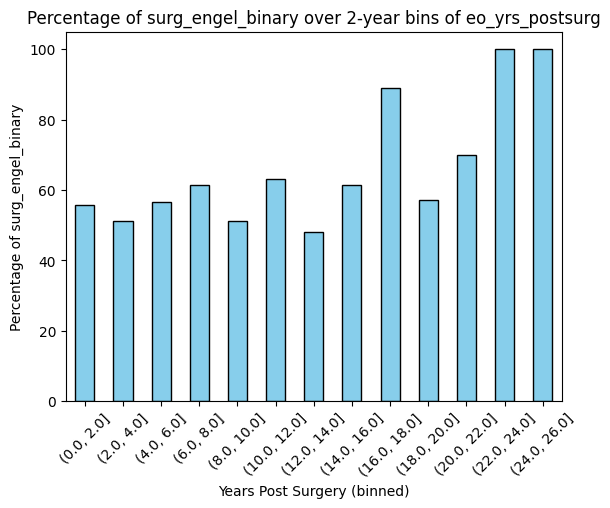

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Bin the eo_yrs_postsurg column into 2-year intervals
bin_size = 2
bins = np.arange(0, wide_df['eo_yrs_postsurg'].max() + bin_size, bin_size)
wide_df['binned'] = pd.cut(wide_df['eo_yrs_postsurg'], bins)

# Calculate the percentage of surg_engel_binary for each bin
bin_percentages = wide_df.groupby('binned')['surg_engel_binary'].mean() * 100

# Plot the results
bin_percentages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Years Post Surgery (binned)')
plt.ylabel('Percentage of surg_engel_binary')
plt.title('Percentage of surg_engel_binary over 2-year bins of eo_yrs_postsurg')
plt.xticks(rotation=45)
plt.show()

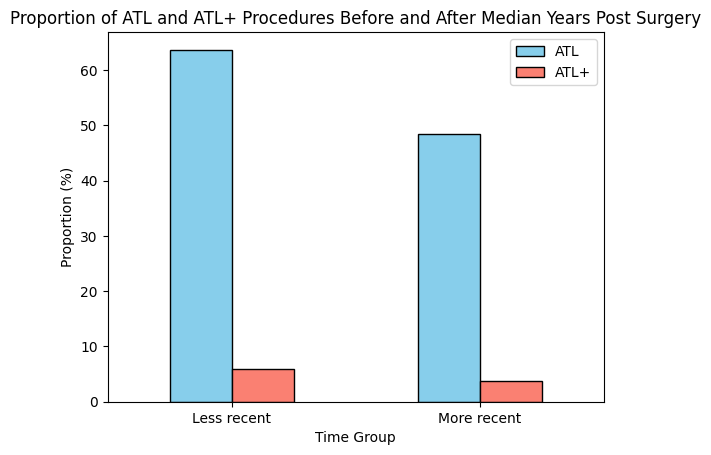

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the median of eo_yrs_postsurg
median_years = wide_df['eo_yrs_postsurg'].median()

# Create a new column that categorizes each entry as 'Before Median' or 'After Median'
wide_df['time_group'] = np.where(wide_df['eo_yrs_postsurg'] <= median_years, 'More recent', 'Less recent')

# Calculate the proportion of ATL (resect_procedure___2) and ATL+ (resect_procedure___3) in each time group
proportions = wide_df.groupby('time_group')[['resect_procedure___2', 'resect_procedure___3']].mean() * 100

# Plot the results
proportions.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Time Group')
plt.ylabel('Proportion (%)')
plt.title('Proportion of ATL and ATL+ Procedures Before and After Median Years Post Surgery')
plt.xticks(rotation=0)
plt.legend(['ATL', 'ATL+'])
plt.show()

In [68]:
only_ATLs = wide_df[(wide_df["resect_procedure___2"]==1) ]

print("Precentage of seizure freedom in ATLs:", only_ATLs["surg_engel_binary"].sum() / len(only_ATLs) * 100, "%")

Precentage of seizure freedom in ATLs: 70.67901234567901 %


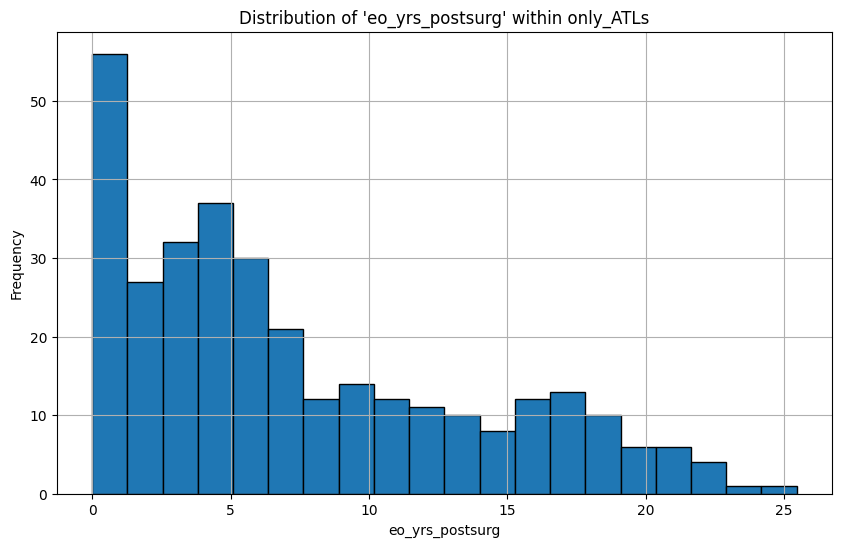

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(only_ATLs["eo_yrs_postsurg"].dropna(), bins=20, edgecolor='black')

plt.title("Distribution of 'eo_yrs_postsurg' within only_ATLs")
plt.xlabel("eo_yrs_postsurg")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()